In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
YEAR = 2022

In [26]:
def read_file(year):
    PATH = f'../dataset/imbank_customer_data/iMBANK_CUSTOMER_DATA_{year}(K-DigitalTraining).csv'
    df = pd.read_csv(PATH, encoding='euc-kr', usecols=['기준년월', '고객ID', '연령대'])
    df = df.sort_values(by='기준년월', ascending=True).reset_index(drop=True)
    return df

CS = read_file(YEAR)

In [27]:
def read_file1(year):
    PATH = f'../dataset/imbank_card_data/iMBANK_CARD_DATA_{year}(K-DigitalTraining).csv'
    df = pd.read_csv(PATH, encoding='euc-kr', usecols=['거래년월', '고객ID'])
    df = df.sort_values(by='거래년월', ascending=True).reset_index(drop=True)
    return df
C = read_file1(YEAR)

In [28]:
# 거래년월이 202212 이전인 데이터 필터링 -> 12월 안가져가도 되나???? 
filtered_data = C[C['거래년월'] < int(f"{YEAR}12")]

# 마지막 거래년월 찾기
last_transaction = filtered_data.groupby('고객ID')['거래년월'].max().reset_index()
last_transaction.columns = ['고객ID', '마지막 거래년월']
last_transaction.tail()

,고객ID,마지막 거래년월
739292,9999901937,202210
739293,9999918728,202209
739294,9999933174,202211
739295,9999981183,202211
739296,9999998161,202207


In [29]:
# 고객ID 기준 Data_frame merge
merge_card = pd.merge(C, last_transaction, on='고객ID', how='inner')
merge_card.tail(15)

,거래년월,고객ID,마지막 거래년월
62915133,202212,5946674163,202211
62915134,202212,5939956857,202211
62915135,202212,5128581778,202211
62915136,202212,8360876341,202211
62915137,202212,9731736685,202211
62915138,202212,9468456810,202211
62915139,202212,9476232849,202211
62915140,202212,4862663803,202211
62915141,202212,3913986482,202211
62915142,202212,3673581980,202211


In [30]:
merge_card.shape

(62915148, 3)

In [ ]:
# 거래이후 소요시간 계산 
current_year_month = int(YEAR*100 +11)
merge_card['거래이후소요기간'] = ((current_year_month // 100 - merge_card['마지막 거래년월'] // 100) * 12 +
                                        (current_year_month % 100 - merge_card['마지막 거래년월'] % 100))

In [32]:
# 거래년월 컬럼 삭제 
new_card = merge_card.drop(columns=['거래년월'])

In [33]:
#마지막컬럼 남기고 중복 제거 -> 거래이후소요기간은 동일 값이라 정렬 필요 없음
new_card = new_card.drop_duplicates(subset='고객ID', keep='last').reset_index(drop=True)
new_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739297 entries, 0 to 739296
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   고객ID      739297 non-null  int64
 1   마지막 거래년월  739297 non-null  int64
 2   거래이후소요기간  739297 non-null  int64
dtypes: int64(3)
memory usage: 16.9 MB


In [34]:
new_card.shape

(739297, 3)

In [35]:
# 이탈 여부 판단
new_card['이탈여부'] = np.where(new_card['거래이후소요기간'] > 1,'이탈', '유지')

In [36]:
new_card.groupby(['이탈여부']).count()

,고객ID,마지막 거래년월,거래이후소요기간
이탈여부,,,
유지,593349,593349,593349
이탈,145948,145948,145948


In [37]:
# CS 데이터 기준년월컬럼 삭제 및 고객ID 중복 거거
CS = CS.drop(columns='기준년월')

In [38]:
# card_2023 & CS_2023 merge
last = new_card.merge(CS, on=['고객ID'], how='inner')

# 고객 ID 중복 제거
last = last.drop_duplicates(subset='고객ID', keep='last').reset_index(drop=True)
last.head()

,고객ID,마지막 거래년월,거래이후소요기간,이탈여부,연령대
0,6503145269,202201,10,이탈,60대이상
1,5041154752,202201,10,이탈,40대
2,5325693421,202201,10,이탈,60대이상
3,6557853606,202201,10,이탈,40대
4,7875215733,202201,10,이탈,60대이상


In [39]:
last.shape

(728737, 5)

In [40]:
# 서머리 결과 DF 형태로 저장
summary = pd.DataFrame(last.groupby(['이탈여부','연령대'])['고객ID'].count())
summary = summary.reset_index()

In [41]:
# 유지와 이탈 고객의 전체 수
total유지 = summary[summary['이탈여부'] == '유지']['고객ID'].sum()
total이탈 = summary[summary['이탈여부'] == '이탈']['고객ID'].sum()

# 비율 계산
summary['비율'] = summary.apply(lambda row: row['고객ID'] / total유지 if row['이탈여부'] == '유지' else
                      (row['고객ID'] / total이탈 if row['이탈여부'] == '이탈' else 0), axis=1)

# 결과 출력
summary

,이탈여부,연령대,고객ID,비율
0,유지,10대미만,28071,0.048047
1,유지,20대,83168,0.142351
2,유지,30대,76235,0.130485
3,유지,40대,106119,0.181634
4,유지,50대,135525,0.231966
5,유지,60대이상,155127,0.265517
6,이탈,10대미만,6521,0.045131
7,이탈,20대,29447,0.203797
8,이탈,30대,23316,0.161365
9,이탈,40대,27659,0.191422


In [42]:
# 중복 확인
dupl = summary['고객ID'].duplicated().any()
if dupl:
    print('중복')
else:
    print('중복아님')

중복아님


In [43]:
# 시각화 그리기 한글폰트 가가
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

In [44]:
last

,고객ID,마지막 거래년월,거래이후소요기간,이탈여부,연령대
0,6503145269,202201,10,이탈,60대이상
1,5041154752,202201,10,이탈,40대
2,5325693421,202201,10,이탈,60대이상
3,6557853606,202201,10,이탈,40대
4,7875215733,202201,10,이탈,60대이상
...,...,...,...,...,...
728732,3605837880,202211,0,유지,20대
728733,3557972915,202211,0,유지,20대
728734,3083154411,202211,0,유지,20대
728735,9963103588,202211,0,유지,50대


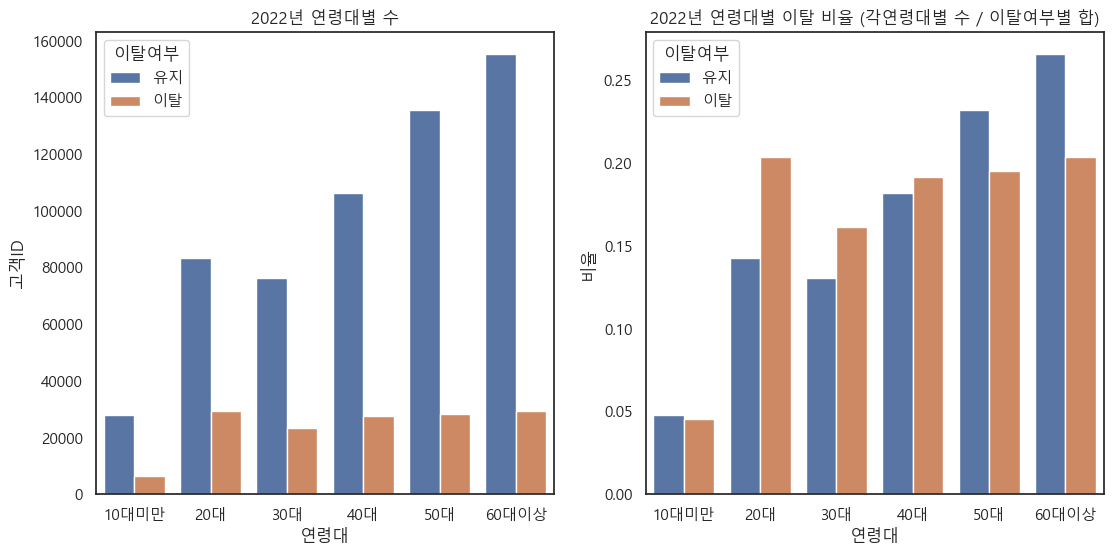

In [45]:
fig, ax = plt.subplots(figsize = (13,6), ncols=2)
sns.barplot(summary, x='연령대', y = '고객ID', hue='이탈여부', ax=ax[0])
sns.barplot(summary, x='연령대', y = '비율', hue='이탈여부', ax=ax[1])

ax[0].set_title(f'{YEAR}년 연령대별 수', )
ax[1].set_title(f'{YEAR}년 연령대별 이탈 비율 (각연령대별 수 / 이탈여부별 합)')
plt.show()

In [46]:
last.to_csv(f'../dataset/summary_{YEAR}.csv', index=False, encoding="utf-8-sig")